### Check Hardware & RAM availability:
Commands to check for available GPU and ram allocation on runtime

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Sun Dec  1 14:29:55 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.06             Driver Version: 535.183.06   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:07:00.0 Off |                    0 |
| N/A   36C    P0              55W / 400W |      3MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [2]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

Your runtime has 1082.0 gigabytes of available RAM



### References:

* https://huggingface.co/
* https://arxiv.org/abs/1906.08237

### Install Required Libraries for Transformer Models:

* Pre-Trained Transformer models are part of Hugging Face Library(transformers).
* Similarly, any datatset part of Hugging Face can be called from the **datasets** library.
* Finally we will use a high level abstraction package called **k-train** to simplify our modelling and predictions

In [3]:
!pip install ktrain
!pip install transformers
!pip install datasets

     |████████████████████████████████| 25.3 MB 1.3 MB/s 
     |████████████████████████████████| 6.8 MB 37.4 MB/s 
     |████████████████████████████████| 981 kB 51.4 MB/s 
     |████████████████████████████████| 263 kB 57.6 MB/s 
     |████████████████████████████████| 1.9 MB 51.3 MB/s 
     |████████████████████████████████| 1.2 MB 50.9 MB/s 
     |████████████████████████████████| 468 kB 67.4 MB/s 
     |████████████████████████████████| 3.3 MB 34.3 MB/s 
     |████████████████████████████████| 895 kB 41.5 MB/s 
  Created wheel for ktrain: filename=ktrain-0.27.3-py3-none-any.whl size=25283131 sha256=95eb19c8c7fde36da5ee5aeee3b3099a36610479f288720df050aefb804df974
  Stored in directory: /root/.cache/pip/wheels/3c/ef/e1/7da805d8a5944e8a3ac0553831d832c00b1800b848939849cb
  Created wheel for seqeval: filename=seqeval-0.0.19-py3-none-any.whl size=9929 sha256=3ba86fdd1b6d1848602a0b3ba82c58e77ddba06f19b8d9bb8f79f6ac85e22076
  Stored in directory: /root/.cache/pip/wheels/f5/ac/f1/4e13d7aff

### Import Libraries:

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ktrain
from ktrain import text
import tensorflow as tf
from sklearn.model_selection import train_test_split
# from datasets import list_datasets
from datasets import load_dataset
from sklearn.metrics import classification_report, confusion_matrix
import timeit
import warnings

pd.set_option('display.max_columns', None)
warnings.simplefilter(action="ignore")

### Load Emotion Dataset:

In [4]:
emotion_train = load_dataset('emotion', split='train')
emotion_val = load_dataset('emotion', split='validation')
emotion_test = load_dataset('emotion', split='test')
print("Details for Emotion Train Dataset: ", emotion_train.shape)
print("Details for Emotion Validation Dataset: ", emotion_val.shape)
print("Details for Emotion Test Dataset: ", emotion_test.shape)

Details for Emotion Train Dataset:  (16000, 2)
Details for Emotion Validation Dataset:  (2000, 2)
Details for Emotion Test Dataset:  (2000, 2)


In [5]:
print("\nTrain Dataset Features for Emotion: \n", emotion_train.features)
print("\nTest Dataset Features for Emotion: \n", emotion_val.features)
print("\nTest Dataset Features for Emotion: \n", emotion_test.features)


Train Dataset Features for Emotion: 
 {'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}

Test Dataset Features for Emotion: 
 {'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}

Test Dataset Features for Emotion: 
 {'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}


### Create DataFrame object:
For modelling, it is required to convert the dataset object into a dataframe object

In [6]:
emotion_train_df = pd.DataFrame(data=emotion_train)
emotion_val_df = pd.DataFrame(data=emotion_val)

In [7]:
class_label_names = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

### Instantiating a XLNet Instance:
Create a XLNet instance with the model name, max token length, the labels to be used for each category and the batch size.
* 1 error will come based on the tensor size

In [8]:
xlnet_transformer = text.Transformer('xlnet-base-cased', maxlen=128, classes = class_label_names, batch_size=32)

### Split Train & Validation data:

In [9]:
X_train = emotion_train_df[:]["text"]
y_train = emotion_train_df[:]["label"]
print(X_train.shape, y_train.shape)

(16000,) (16000,)


**Note Shape of dataframe below:**

In [10]:
X_test = emotion_val_df[:1984]["text"]
y_test = emotion_val_df[:1984]["label"]
print(X_test.shape, y_test.shape)

(1984,) (1984,)


### Perform Data Preprocessing:

In [11]:
xlnet_train = xlnet_transformer.preprocess_train(X_train.to_list(), y_train.to_list())
xlnet_val = xlnet_transformer.preprocess_test(X_test.to_list(), y_test.to_list())

preprocessing train...
language: en
train sequence lengths:
	mean : 19
	95percentile : 41
	99percentile : 52


spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.38M [00:00<?, ?B/s]

Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 19
	95percentile : 40
	99percentile : 52


### Compile XLNet in a K-Train Learner Object:
Since we are using k-train as a high level abstration package, we need to wrap our model in a k-train Learner Object for further compuation

In [12]:
xlnet_model = xlnet_transformer.get_classifier()

In [13]:
xlnet_learner_ins = ktrain.get_learner(model=xlnet_model,
                            train_data=xlnet_train,
                            val_data=xlnet_val,
                            batch_size=32)

### XLNet Model Details:

In [14]:
xlnet_learner_ins.model.summary()

Model: "tfxl_net_for_sequence_classification_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 transformer (TFXLNetMainLa  multiple                  116718336 
 yer)                                                            
                                                                 
 sequence_summary (TFSequen  multiple                  590592    
 ceSummary)                                                      
                                                                 
 logits_proj (Dense)         multiple                  4614      
                                                                 
Total params: 117313542 (447.52 MB)
Trainable params: 117313542 (447.52 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Find Optimal Learning Rate for XLNet:

Again an optional step used just to show how the learning rate can be found for any transformer model. For Transformer models as per the research papers, the optimal learning rates have already been estimated and established.

simulating training for different learning rates... this may take a few moments...
Epoch 1/3
500/500 [==============================] - 131s 231ms/step - loss: 1.5151 - accuracy: 0.3762
Epoch 2/3
500/500 [==============================] - 117s 231ms/step - loss: 1.7765 - accuracy: 0.4977
Epoch 3/3
500/500 [==============================] - 4s 3ms/step - loss: 8.9712 - accuracy: 0.1875


done.
Visually inspect loss plot and select learning rate associated with falling loss


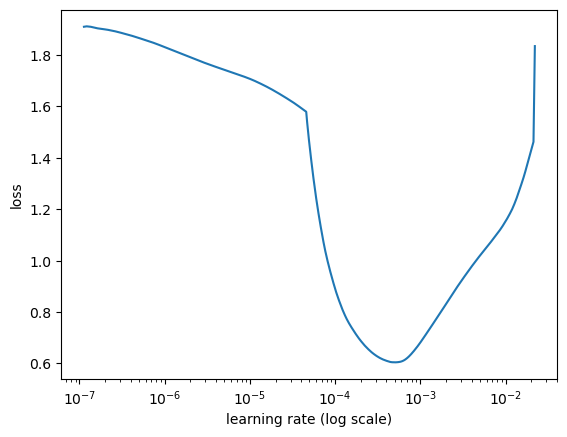


Total time in minutes on estimating optimal learning rate: 
 4.319191769283497


In [15]:
rate_finder_start_time = timeit.default_timer()
xlnet_learner_ins.lr_find(show_plot=True, max_epochs=3)
rate_finder_stop_time = timeit.default_timer()

print("\nTotal time in minutes on estimating optimal learning rate: \n", (rate_finder_stop_time - rate_finder_start_time)/60)

### XLNet Optimal Learning Rates:
In general for all transformer models and as per the research paper analysis suggests these : {1e−5, 2e−5, 3e−5} as the best choices for learning rates.

### Fine Tuning XLNet on Emotion Dataset:
We take our emotion dataset along with the XLNet model, define the learning-rate & epochs to be used and start fine-tuning.

In [16]:
xlnet_fine_tune_start_time = timeit.default_timer()
xlnet_learner_ins.fit_onecycle(lr=2e-5, epochs=3)
xlnet_fine_tune_stop_time = timeit.default_timer()

print("\nTotal time in minutes for Fine-Tuning XLNet on Emotion Dataset: \n", (xlnet_fine_tune_stop_time - xlnet_fine_tune_start_time)/60)



begin training using onecycle policy with max lr of 2e-05...
Epoch 1/3
500/500 [==============================] - 132s 243ms/step - loss: 0.9059 - accuracy: 0.6683 - val_loss: 0.3094 - val_accuracy: 0.8982
Epoch 2/3
500/500 [==============================] - 120s 240ms/step - loss: 0.2521 - accuracy: 0.9059 - val_loss: 0.1605 - val_accuracy: 0.9289
Epoch 3/3
500/500 [==============================] - 120s 239ms/step - loss: 0.1311 - accuracy: 0.9435 - val_loss: 0.1430 - val_accuracy: 0.9279

Total time in minutes for Fine-Tuning XLNet on Emotion Dataset: 
 6.1920530281834845


### Checking XLNet performance metrics:

In [17]:
xlnet_learner_ins.validate(class_names=class_label_names)

62/62 [==============================] - 6s 54ms/step
              precision    recall  f1-score   support

     sadness       0.95      0.96      0.96       547
         joy       0.97      0.93      0.95       698
        love       0.83      0.91      0.87       177
       anger       0.93      0.92      0.92       272
        fear       0.86      0.90      0.88       210
    surprise       0.85      0.80      0.83        80

    accuracy                           0.93      1984
   macro avg       0.90      0.90      0.90      1984
weighted avg       0.93      0.93      0.93      1984



array([[527,   2,   0,   8,  10,   0],
       [  5, 649,  33,   2,   3,   6],
       [  2,  14, 161,   0,   0,   0],
       [ 13,   1,   1, 251,   6,   0],
       [  6,   0,   0,  10, 189,   5],
       [  2,   2,   0,   0,  12,  64]])

In [18]:
xlnet_learner_ins.view_top_losses(preproc=xlnet_transformer)

62/62 [==============================] - 3s 52ms/step
----------
id:1658 | loss:6.74 | true:love | pred:sadness)

----------
id:177 | loss:6.64 | true:sadness | pred:joy)

----------
id:465 | loss:6.18 | true:joy | pred:fear)

----------
id:1963 | loss:5.69 | true:joy | pred:sadness)



### Saving XLNet Model:

In [19]:
xlnet_predictor = ktrain.get_predictor(xlnet_learner_ins.model, preproc=xlnet_transformer)
xlnet_predictor.get_classes()

['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

In [20]:
xlnet_predictor.save('xlnet-emotion-predictor')

In [21]:
!zip -r xlnet-emotion-predictor xlnet-emotion-predictor

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  adding: xlnet-emotion-predictor/ (stored 0%)
  adding: xlnet-emotion-predictor/special_tokens_map.json (deflated 52%)
  adding: xlnet-emotion-predictor/tf_model.h5 (deflated 7%)
  adding: xlnet-emotion-predictor/tf_model.preproc (deflated 46%)
  adding: xlnet-emotion-predictor/tokenizer_config.json (deflated 82%)
  adding: xlnet-emotion-predictor/config.json (deflated 55%)
  adding: xlnet-emotion-predictor/spiece.model (deflated 49%)
  adding: xlnet-emotion-predictor/tokenizer.json (deflated 75%)


### Loading Saved Model for New Predictions:

In [23]:
xlnet_predictor_new = ktrain.load_predictor('xlnet-emotion-predictor')
xlnet_predictor_new.get_classes()

['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

### Load Test data split:

In [24]:
emotion_test_df = pd.DataFrame(data=emotion_test)
emotion_test_df.head()

,text,label
0,im feeling rather rotten so im not very ambiti...,0
1,im updating my blog because i feel shitty,0
2,i never make her separate from me because i do...,0
3,i left with my bouquet of red and yellow tulip...,1
4,i was feeling a little vain when i did this one,0


In [25]:
emotion_test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    2000 non-null   object
 1   label   2000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


### Modify dataframe for label mis-match:

In [26]:
label_dict = {0: "sadness", 1: "joy", 2: "love", 3: "anger", 4: "fear", 5: "surprise"}
emotion_test_df["label"] = emotion_test_df["label"].map(label_dict)
emotion_test_df.head()

,text,label
0,im feeling rather rotten so im not very ambiti...,sadness
1,im updating my blog because i feel shitty,sadness
2,i never make her separate from me because i do...,sadness
3,i left with my bouquet of red and yellow tulip...,joy
4,i was feeling a little vain when i did this one,sadness


In [27]:
emotion_test_df[emotion_test_df.columns] = emotion_test_df[emotion_test_df.columns].astype(str)
emotion_test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    2000 non-null   object
 1   label   2000 non-null   object
dtypes: object(2)
memory usage: 31.4+ KB


**Note Data split below:**

In [28]:
X_test_new = emotion_test_df[:1984]["text"]
y_test_new = emotion_test_df[:1984]["label"]
print(X_test_new.shape, y_test_new.shape)

(1984,) (1984,)


### Use test data as new prediction data:

In [29]:
test_predictions = xlnet_predictor_new.predict(X_test_new.to_list())

---------------------------------------------------------------------------

* InvalidArgumentError                      Traceback (most recent call last)
<ipython-input-30-af9b6e256fba> in <module>()
----> 1 test_predictions = xlnet_predictor_new.predict(X_test_new.to_list())


* usr/local/lib/python3.7/dist-packages/six.py in raise_from(value, from_value)

* InvalidArgumentError: ConcatOp : Dimensions of inputs should match: shape[0] = [75,32,768] vs. shape[62] = [75,16,768] [Op:ConcatV2] name: concat

### View Performance Metrics on new test data:

In [30]:
print(confusion_matrix(y_test_new, test_predictions))

[[245  12   3   0  10   0]
 [  4 208   0   0   6   4]
 [  3   1 638  39   6   5]
 [  1   0  13 142   1   0]
 [ 10   6   4   0 557   0]
 [  0  14   0   0   3  49]]


In [31]:
print(classification_report(y_test_new, test_predictions))

              precision    recall  f1-score   support

       anger       0.93      0.91      0.92       270
        fear       0.86      0.94      0.90       222
         joy       0.97      0.92      0.95       692
        love       0.78      0.90      0.84       157
     sadness       0.96      0.97      0.96       577
    surprise       0.84      0.74      0.79        66

    accuracy                           0.93      1984
   macro avg       0.89      0.90      0.89      1984
weighted avg       0.93      0.93      0.93      1984



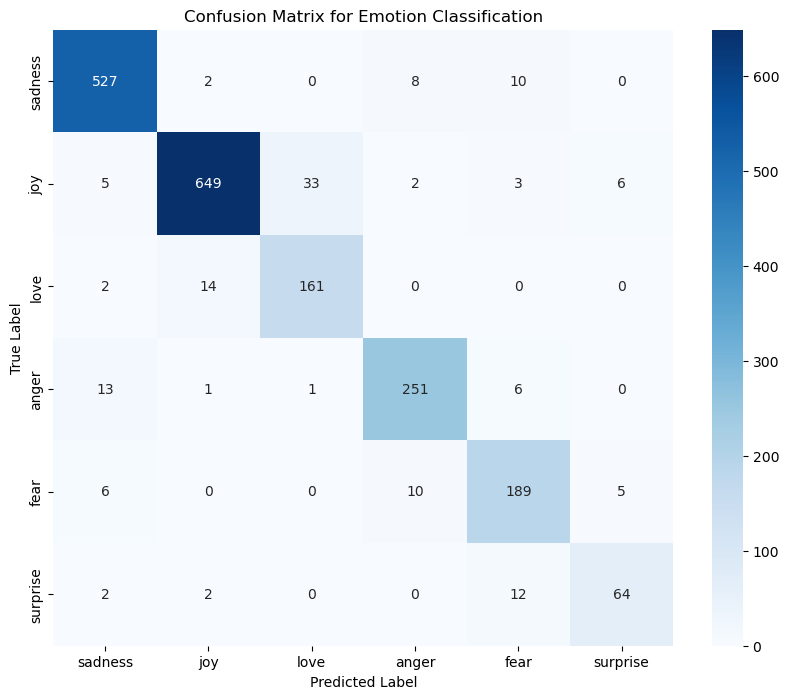

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

# Confusion matrix data (example from your output)
cm = np.array([[527, 2, 0, 8, 10, 0],
               [5, 649, 33, 2, 3, 6],
               [2, 14, 161, 0, 0, 0],
               [13, 1, 1, 251, 6, 0],
               [6, 0, 0, 10, 189, 5],
               [2, 2, 0, 0, 12, 64]])

# Class labels
labels = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, cbar=True)

# Add title and labels
plt.title('Confusion Matrix for Emotion Classification')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Show the plot
plt.show()
